# Computational chemistry workflow with Jupyter notebook

- Exercise for SSCC-19
- Markus Rauhalahti, markus.rauhalahti@helsinki.fi, mrauha.github.io

- For setting up, see README.md

## Used libraries

In [1]:
# General
import os

# Data wrangling
import pandas as pd
import numpy as np
import deepdish


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

## Reading in the molecules

- Fragrance dataset from [GDB](http://gdb.unibe.ch/)
    - [Ruddigkeit, Lars, Mahendra Awale, and Jean-Louis Reymond. "Expanding the fragrance chemical space for virtual screening." Journal of cheminformatics 6.1 (2014): 27](https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-6-27)
- In Simplified molecular-input line-entry system (SMILES) format, see [wiki](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
    - String representation of molecular graph. Only connectivity, elements, valence, charge information - no 3D structures.
   
- From these, the molecules with no rotatable bonds were chosen and converted to a .xyz format (2D $\to$ 3D). 
    - This was done using rdkit. 
- The input data is given as a pandas dataframe. 

In [6]:
rigid_molecules = pd.read_pickle("rigid_molecules.pkl")
print("Number of molecules: {}".format(rigid_molecules.shape[0]))
rigid_molecules.head(n=2)

Number of molecules: 183


,SMILES,NRotBonds,xyz
0,C1C2CCCCC12,0,19\n\nC 2.0889 -0.2624 -0.2700\nC 0.9608 ...
1,C1=CC2=C(C=C1)C=CC=C2,0,18\n\nC 2.3965 -0.1280 -0.7519\nC 1.2891 ...


# Time to calculate some properties!

- We want to optimize the molecular geometries and obtain some molecular properties
- Input files are written in ./orca_calculations/{system_index}

In [44]:
calcbase = os.path.join(os.getcwd(), "orca_calculations")

for system_index, row in rigid_molecules.iterrows():
    #if system_index > 0: break
    xyz = row["xyz"]    
    xyz_no_header = "\n".join(xyz.split("\n")[2:])
    orca_input = "! b97-3c opt\n%maxcore 5000\n* xyz 0 1\n{}\n*".format(xyz_no_header)
    
    # Write input files 
    
    calcdir = os.path.join(calcbase, str(system_index))
    if not os.path.exists(calcdir):
        os.makedirs(calcdir)
        
    with open(os.path.join(calcdir, "orca.inp"), 'w') as f:
        f.write(orca_input)
        

The inputs look like this:

```
! b97-3c opt                 <- geometry optimization using the b97-3c method
%maxcore 5000                <- memory per core
* xyz 0 1                    <- charge, multiplicity
C  1.8375  -0.2027  -0.3278  <- xyz coordinates
...
*
```

- This is then sent to taito, let's say to $WRKDIR/wflow_example. 

- In this directory, we get the paths of the input files and save to calcdirs.txt

```bash
for i in $(find $(pwd) -name "*inp"); do echo $(dirname $i); done > calcdirs.txt
```
- SLURM array job:

```
#!/bin/bash -l
#SBATCH -p serial
#SBATCH -n 1             # total nuber of cores  
#SBATCH -t 01:00:00        # time as hh:mm:ss
#SBATCH -J array_hc_FNAME
#SBATCH -e arrayjob_%A_%a.err
#SBATCH -o arrayjob_%A_%a.out
#SBATCH --mem-per-cpu=5000  # requested memory per process in MB
#SBATCH --array=1-183

SDIR=$(pwd)
module load orca-env/4.0.1.2


dir=$(sed -n "$SLURM_ARRAY_TASK_ID"p calcdirs.txt)


cd $dir

start=$(date +%s)
printf "Starting $dir ..."

$USERAPPL/orca_4_0_1_2_linux_x86-64_openmpi202/orca  orca.inp > orca.out

end=$(date +%s)
runtime=$( echo "$end - $start" | bc -l )
printf "done, time: $runtime s\n"


echo $dir >> $SDIR/donecalcs.txt
cd $SDIR
```

# Parsing the results

- The results are parsed on taito with the following script
- Parsing is done with the [cclib](https://cclib.github.io/) library
- Outputs are saved in .h5 format using deepdish

```python
import cclib
import io
import os
import deepdish

def parse_out(path):
    resdir = {}
    resdir["System"] = system
    try:
        with open(os.path.join(path, "orca.out")) as f:
            inp = f.read()
    except:
        resdir["Error"] : "NoOutput"
        return resdir

    checkline = inp.split("\n")[-3]

    if "ORCA TERMINATED NORMALLY" not in checkline:
        resdir["Error"] = "CalcError"
        return resdir

    try:
        inp_io = io.StringIO(inp)
        parser = cclib.io.ccopen(inp_io)
        data = parser.parse()
        results = cclib.io.cjsonwriter.CJSON(data).as_dict()
        resdir["calcres"] = results
        return resdir
    except:
        resdir["Error"] : "CantParse"
        return resdir

with open(calcpath_file, 'r') as f:
    calcpaths = f.readlines()
calcpaths = [r.strip() for r in calcpaths]

results = {}
for path in calcpaths:
    system = int(path.split("/")[-1])
    result_dict = parse_out(path)
    results[system] = result_dict

deepdish.io.save("cclib_results.h5", results)	
```

## Add HOMO, gap energies to the dataframe

- Transfer the cclib_results.h5 from taito, parse some values
    - In .h5 format, opened with deepdish


In [8]:
cclib_results = deepdish.io.load("cclib_results.h5")

cclib_results is a nested dictionary. Top level key is the system index, and it contains a lot of stuff parsed from the output.

In [9]:
cclib_results[0]["calcres"]["properties"]

{'partial charges': {'mulliken': array([-0.448052, -0.112581, -0.307046, -0.3829  , -0.299734, -0.368526,
         -0.091012,  0.164846,  0.185427,  0.18045 ,  0.153916,  0.160558,
          0.164214,  0.170314,  0.164297,  0.157485,  0.160298,  0.16245 ,
          0.185596]),
  'lowdin': array([-0.303291, -0.199821, -0.284005, -0.302164, -0.292695, -0.286441,
         -0.203216,  0.160971,  0.16146 ,  0.160911,  0.153691,  0.153932,
          0.150793,  0.153688,  0.151259,  0.15234 ,  0.154211,  0.15634 ,
          0.162039])},
 'charge': 0,
 'orbitals': {'homos': array([26], dtype=int32),
  'energies': [array([-269.04584847, -269.04073273, -268.88424005, -268.87327387,
          -268.84796728, -268.81898715, -268.8188511 ,  -21.71588257,
           -19.46378671,  -18.28732969,  -15.96951833,  -14.78193186,
           -14.10298059,  -12.71797551,  -12.29957325,  -11.01440675,
           -10.63671272,  -10.41640935,  -10.1110704 ,   -9.10539203,
            -8.81575405,   -8.35299723,

For our purpose, we only get the HOMO and gap

In [10]:
# prettier ways exist...
rigid_molecules["homo"] = np.nan
rigid_molecules["gap"] = np.nan
rigid_molecules["dipole"] = np.nan


for system_index in cclib_results:
    try:
        homo = cclib_results[system_index]["calcres"]["properties"]["energy"]["alpha"]["homo"]
        gap = cclib_results[system_index]["calcres"]["properties"]["energy"]["alpha"]["gap"]
        dipole = cclib_results[system_index]["calcres"]["properties"]['total dipole moment']
        rigid_molecules.set_value(system_index, "homo" , homo)
        rigid_molecules.set_value(system_index, "gap" , gap)
        rigid_molecules.set_value(system_index, "dipole" , dipole)
    except:
        # Not all molecules have data as their calculation didn't converge
        pass


/home/markus/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/home/markus/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/home/markus/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [11]:
rigid_molecules.head(n=1)

,SMILES,NRotBonds,xyz,homo,gap,dipole
0,C1C2CCCCC12,0,19\n\nC 2.0889 -0.2624 -0.2700\nC 0.9608 ...,-6.184957,6.889542,0.190213


# See how properties are distributed

Text(0, 0.5, 'Count')

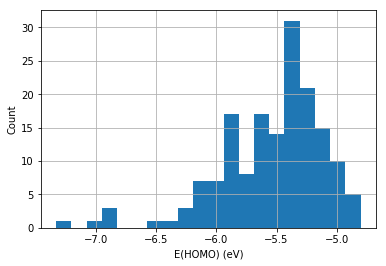

In [12]:
rigid_molecules["homo"].hist(bins=20)
plt.xlabel("E(HOMO) (eV)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

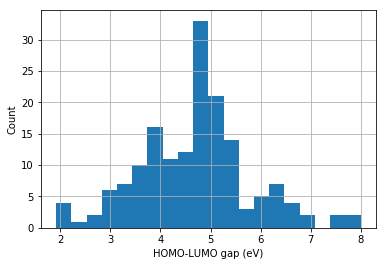

In [13]:
rigid_molecules["gap"].hist(bins=20)
plt.xlabel("HOMO-LUMO gap (eV)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

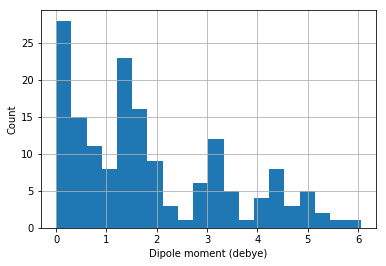

In [14]:
rigid_molecules["dipole"].hist(bins=20)
plt.xlabel("Dipole moment (debye)")
plt.ylabel("Count")

### I wonder if these are correlated...
- Scatter plot: distributions on diagonals, correlations on off-diagonals

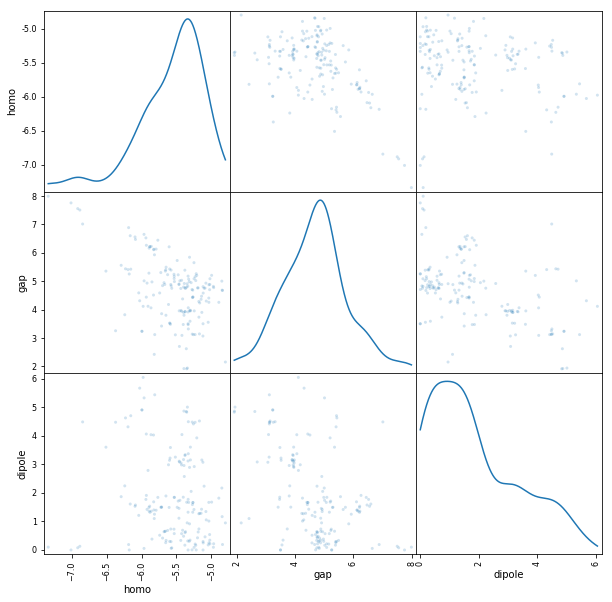

In [15]:
pd.plotting.scatter_matrix(rigid_molecules[["homo", "gap", "dipole"]], alpha=0.2, figsize=(10, 10), diagonal='kde');